In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
from scipy import stats
import otter
set_matplotlib_formats("svg")
plt.style.use('ggplot')

import warnings
warnings.simplefilter('ignore')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animation
from IPython.display import IFrame, display

def show_clt_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vTcJd3U1H1KoXqBFcWGKFUPjZbeW4oiNZZLCFY8jqvSDsl4L1rRTg7980nPs1TGCAecYKUZxH5MZIBh/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 509
    display(IFrame(src, width, height))

# Lecture 27 – Review
## DSC 10, Fall 2022

### Announcements

- The Final Exam is **this Saturday 12/3 from 11:30am to 2:30pm**.
    - More details coming tonight, but start studying!
- There are several study sessions/group office hours this week, which should be helpful as you complete the final project and study for the final exam. Check the [calendar](https://dsc10.com/calendar) for all office hours.
    - Wednesday 11/30 from 3-7pm in SDSC Auditorium (with no heat 🥶; dress warmly 🧣).
    - Friday 12/2 from 5-9pm in WLH 2205.
- If at least 80% of the class fills out both [CAPEs](https://cape.ucsd.edu) and the [End of Quarter Survey](https://docs.google.com/forms/d/e/1FAIpQLSeiZodx0wMHVxC-PfSGXu0mrI2R8XgS1RUzI-VZhZc9TbT3lA/viewform), then we will add 0.5% of extra credit to everyone's overall grade.
    - We read every single piece of feedback!

### Agenda

- No new material – just review!
- If you're attending lecture, fill in the code in the notebook as we go. We'll post the solutions later today.

## The data: Restaurants 🍟

Our data comes from [data.sfgov.org](https://data.sfgov.org/Health-and-Social-Services/Restaurant-Scores-LIVES-Standard/pyih-qa8i/data).

In [12]:
restaurants = bpd.read_csv('data/restaurants_no_null.csv')
restaurants

,Unnamed: 0,business_id,business_name,business_address,...,Supervisor Districts,Fire Prevention Districts,Zip Codes,Analysis Neighborhoods
0,9671,3838,CAFE PICARO,3120 16th St,...,5.0,8.0,28853.0,20.0
1,9679,63619,Subway Sandwiches,77 Van Ness Ave #100,...,9.0,7.0,28852.0,36.0
2,9695,7786,DIANDA'S ITAL-AMER.PASTRY CO.,2883 Mission St,...,7.0,2.0,28859.0,20.0
...,...,...,...,...,...,...,...,...,...
5274,54150,3895,Cable Car Restaurant,1040 Columbus Ave,...,10.0,5.0,308.0,23.0
5275,54202,1668,SILVER CREST DONUT SHOP,340 BAYSHORE Blvd,...,7.0,10.0,58.0,1.0
5276,54203,5820,GLEN PARK ELEMENTARY SCHOOL,151 LIPPARD Ave,...,5.0,9.0,63.0,41.0


It seems like the city for every row is `'San Francisco'`. We can confirm this using `np.unique`:

In [13]:
restaurants.get('business_city').unique()

array(['San Francisco'], dtype=object)

As a result, the `'business_city'` column isn't telling us much. We won't look at many of the columns in our DataFrame, so let's just `get` the ones we're interested in.

In [18]:
keep_cols = ['business_name', 'inspection_date', 'inspection_score', 'risk_category', 'Neighborhoods', 'Zip Codes']
restaurants = restaurants.get(keep_cols)
restaurants

,business_name,inspection_date,inspection_score,risk_category,Neighborhoods,Zip Codes
0,CAFE PICARO,2018-02-22T00:00:00.000,72.0,Low Risk,19.0,28853.0
1,Subway Sandwiches,2017-09-19T00:00:00.000,92.0,Low Risk,36.0,28852.0
2,DIANDA'S ITAL-AMER.PASTRY CO.,2017-10-18T00:00:00.000,85.0,Moderate Risk,19.0,28859.0
...,...,...,...,...,...,...
5274,Cable Car Restaurant,2018-03-13T00:00:00.000,82.0,Moderate Risk,23.0,308.0
5275,SILVER CREST DONUT SHOP,2019-02-27T00:00:00.000,84.0,Moderate Risk,1.0,58.0
5276,GLEN PARK ELEMENTARY SCHOOL,2016-09-02T00:00:00.000,88.0,Low Risk,40.0,63.0


## At-risk restaurants ⚠️

For each restaurant, we have an inspection score.

In [19]:
restaurants.take(np.arange(5))

,business_name,inspection_date,inspection_score,risk_category,Neighborhoods,Zip Codes
0,CAFE PICARO,2018-02-22T00:00:00.000,72.0,Low Risk,19.0,28853.0
1,Subway Sandwiches,2017-09-19T00:00:00.000,92.0,Low Risk,36.0,28852.0
2,DIANDA'S ITAL-AMER.PASTRY CO.,2017-10-18T00:00:00.000,85.0,Moderate Risk,19.0,28859.0
3,KEZAR PUB,2017-12-15T00:00:00.000,91.0,High Risk,9.0,29492.0
4,Piccadilly Fish & Chips,2016-10-24T00:00:00.000,90.0,Low Risk,21.0,28858.0


In the preview above, we see...
- A restaurant with an inspection score of 92 being classified as `'Low Risk'`,
- A restaurant with an inspection score of 91 being classified as `'High Risk'`
- A restaurant with an inspection score of 90 being classified as `'Low Risk'`

This means that inspection scores don't directly translate to risk categories. Let's investigate the difference between the inspection scores of low risk and high risk restaurants.

Let's start by visualizing the distribution of inspection scores for low risk and high risk restaurants.

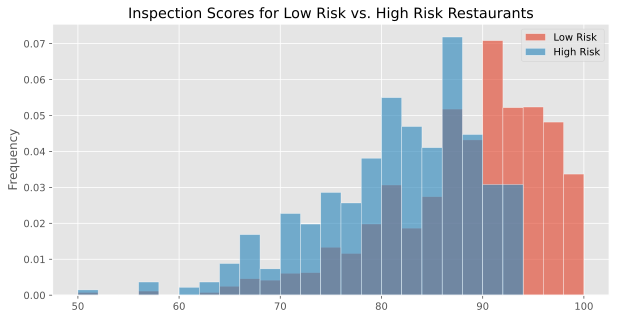

In [20]:
# Don't worry about the plotting code here.
fig, ax = plt.subplots()
score_bins = np.arange(50, 102, 2)
restaurants[restaurants.get('risk_category') == 'Low Risk'].plot(
    kind='hist', y='inspection_score', density=True, ec='w', bins=score_bins, ax=ax,
    figsize=(10, 5), title='Inspection Scores for Low Risk vs. High Risk Restaurants', alpha=0.65, label='Low Risk'
);

restaurants[restaurants.get('risk_category') == 'High Risk'].plot(
    kind='hist', y='inspection_score', density=True, ec='w', bins=score_bins, ax=ax,
    figsize=(10, 5), alpha=0.65, label='High Risk'
);

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

We want to compare high risk restaurants to low risk restaurants and see if their inspection scores are significantly different. What technique should we use?

A. Standard hypothesis testing

B. Permutation testing  

C. Bootstrapping

D. The Central Limit Theorem

<details>
<summary>Click for the answer <b>after</b> you've entered your guess above. <b>Don't scroll any further.</b></summary>
    
Permutation testing.

</details>

Let's keep only the relevant information.

In [30]:
high_low = restaurants[(restaurants.get('risk_category') == 'Low Risk') | (restaurants.get('risk_category') == 'High Risk')]
high_low = high_low.get(['inspection_score', 'risk_category'])
high_low

,inspection_score,risk_category
0,72.0,Low Risk
1,92.0,Low Risk
3,91.0,High Risk
...,...,...
5266,90.0,Low Risk
5272,62.0,High Risk
5276,88.0,Low Risk


Now, let's try shuffling a single one of the columns above. (Does it matter which one?)

In [31]:
np.random.permutation(high_low.get('risk_category'))

array(['Low Risk', 'High Risk', 'High Risk', ..., 'Low Risk', 'Low Risk',
       'High Risk'], dtype=object)

Let's assign this shuffled column back into our original DataFrame. The resulting DataFrame is called `original_and_shuffled`.

In [33]:
shuffled_labels = np.random.permutation(high_low.get('risk_category'))
original_and_shuffled = high_low.assign(shuffled_label=shuffled_labels)
original_and_shuffled

,inspection_score,risk_category,shuffled_label
0,72.0,Low Risk,Low Risk
1,92.0,Low Risk,Low Risk
3,91.0,High Risk,Low Risk
...,...,...,...
5266,90.0,Low Risk,Low Risk
5272,62.0,High Risk,Low Risk
5276,88.0,Low Risk,High Risk


Let's now visualize the distribution of inspection scores for low risk and high risk restaurants, in both our original dataset and after shuffling the labels.

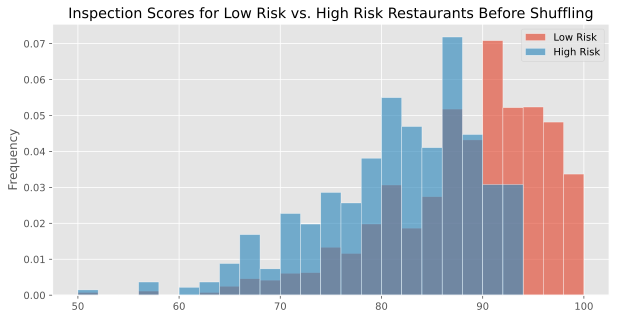

In [34]:
# Don't worry about the plotting code here.
fig, ax = plt.subplots()
score_bins = np.arange(50, 102, 2)
restaurants[restaurants.get('risk_category') == 'Low Risk'].plot(
    kind='hist', y='inspection_score', density=True, ec='w', bins=score_bins, ax=ax,
    figsize=(10, 5), title='Inspection Scores for Low Risk vs. High Risk Restaurants Before Shuffling', alpha=0.65, label='Low Risk'
);

restaurants[restaurants.get('risk_category') == 'High Risk'].plot(
    kind='hist', y='inspection_score', density=True, ec='w', bins=score_bins, ax=ax,
    figsize=(10, 5), alpha=0.65, label='High Risk'
);

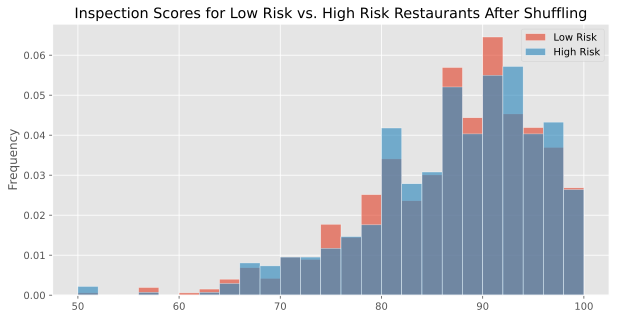

In [35]:
# Don't worry about the plotting code here.
fig, ax = plt.subplots()
score_bins = np.arange(50, 102, 2)
original_and_shuffled[original_and_shuffled.get('shuffled_label') == 'Low Risk'].plot(
    kind='hist', y='inspection_score', density=True, ec='w', bins=score_bins, ax=ax,
    figsize=(10, 5), title='Inspection Scores for Low Risk vs. High Risk Restaurants After Shuffling', alpha=0.65, label='Low Risk'
);

original_and_shuffled[original_and_shuffled.get('shuffled_label') == 'High Risk'].plot(
    kind='hist', y='inspection_score', density=True, ec='w', bins=score_bins, ax=ax,
    figsize=(10, 5), alpha=0.65, label='High Risk'
);

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

It looks like the two groups in the second histogram are substantially more different than the two groups in the first histogram. 

What test statistic(s) can we use to quantify the difference between the two groups displayed in a given histogram?

A. Total variation distance  
B. Difference in group means  
C. Either of the above

<details>
<summary>Click for the answer <b>after</b> you've entered your guess above. <b>Don't scroll any further.</b></summary>
    
Difference in group means. TVD helps compare two categorical distributions, but we're dealing with two numerical distributions.

</details>

In [36]:
original_and_shuffled.groupby('risk_category').mean()

,inspection_score
risk_category,
High Risk,81.24
Low Risk,87.75


Let's compute the difference in mean inspection scores for the low risk group and high risk group (low minus high).

First, for our observed data:

In [41]:
grouped = original_and_shuffled.groupby('risk_category').mean()
observed_difference = grouped.get('inspection_score').loc['Low Risk'] - grouped.get('inspection_score').loc['High Risk']
observed_difference

6.5084648663377465

Then, for our shuffled data:

In [42]:
original_and_shuffled.groupby('shuffled_label').mean()

,inspection_score
shuffled_label,
High Risk,86.52
Low Risk,86.37


In [44]:
shuffled_and_grouped = original_and_shuffled.groupby('shuffled_label').mean()
simulated_difference = shuffled_and_grouped.get('inspection_score').loc['Low Risk'] - shuffled_and_grouped.get('inspection_score').loc['High Risk']
simulated_difference

-0.14288091340151254

We're going to need to shuffle the `'risk_category'` column many, many times, and compute this difference in group means each time.

Let's put some of our code in a function to make it easier to repeat.

In [45]:
def calculate_test_statistic():
    shuffled_labels = np.random.permutation(high_low.get('risk_category'))
    original_and_shuffled = high_low.assign(shuffled_label=shuffled_labels)
    shuffled_and_grouped = original_and_shuffled.groupby('shuffled_label').mean()
    simulated_difference = shuffled_and_grouped.get('inspection_score').loc['Low Risk'] - shuffled_and_grouped.get('inspection_score').loc['High Risk']
    return simulated_difference

Each time we call this function, it shuffles the `'risk_category'` column and returns the difference in group means (again, by taking low minus high).

In [49]:
calculate_test_statistic()

0.3207369124009176

We need to simulate this difference in group means many, many times. Let's call our function many, many times and keep track of its result in an array.

In [50]:
simulated_stats = np.array([])
n_reps = 100 # We're using a small number of reps to save time in lecture.

for i in range(n_reps):
    simulated_stats = np.append(simulated_stats, calculate_test_statistic())

Now that we've done that, let's visualize the distribution of the simulated test statistics, and also see where the observed statistic lies:

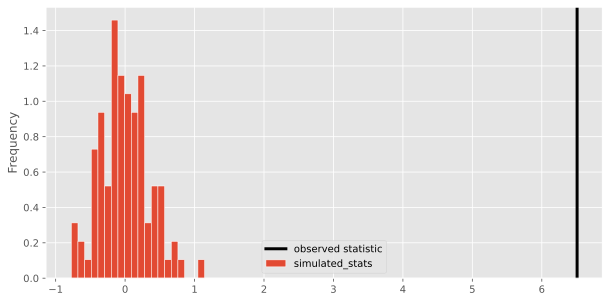

In [51]:
bpd.DataFrame().assign(simulated_stats=simulated_stats) \
               .plot(kind='hist', density=True, ec='w', figsize=(10, 5), bins=20, label='difference in group means');
plt.axvline(observed_difference, lw=3, color='black', label='observed statistic')
plt.legend();

What's the p-value? Well, it depends on what our alternative hypothesis is. Here, our alternative hypothesis is that low risk restaurants have higher inspection scores on average than high risk restaurants. 

Since our test statistic was

$$\text{low risk mean} - \text{high risk mean}$$

larger values of the test statistic favor the alternative.

In [53]:
np.count_nonzero(simulated_stats >= observed_difference) / n_reps

0.0

This is lower than any cutoff we'd consider, so we'd reject the null hypothesis that the two groups of restaurants have similar inspection scores.

## Bakeries 🧁

<center>
<table><tr>
    <td><center><img src='data/pie.jpg'  style="width: 60%;"/></center></td>
    <td><center><img src='data/cupcakes.jpg'  style="width: 60%;"/></center></td>
</tr></table>
</center>

We'll load in a version of the restaurants dataset that has many more rows, some of which contain null values.

In [54]:
restaurants_full = bpd.read_csv('data/restaurants.csv').get(keep_cols)
restaurants_full

,business_name,inspection_date,inspection_score,risk_category,Neighborhoods,Zip Codes
0,Golden Waffle,2018-08-08T00:00:00.000,NaN,NaN,NaN,NaN
1,Hakkasan San Francisco,2018-04-18T00:00:00.000,88.0,Moderate Risk,NaN,NaN
2,Chopsticks Restaurant,2017-08-18T00:00:00.000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
54474,Farmhouse Kitchen Thai Cuisine,2018-10-10T00:00:00.000,NaN,High Risk,NaN,NaN
54475,Wago Sushi,2018-01-30T00:00:00.000,88.0,Moderate Risk,NaN,NaN
54476,Yemen Cafe & Restaurant,2016-05-20T00:00:00.000,76.0,Low Risk,NaN,NaN


Let's look at just the restaurants with `'Bake'` in the name that we know the inspection score for.

`.str.contains` can help us here.

In [55]:
restaurants_full.get('business_name').str.contains('Bake')

0        False
1        False
2        False
         ...  
54474    False
54475    False
54476    False
Name: business_name, Length: 54477, dtype: bool

Some bakeries may have `'bake'` in their name, rather than `'Bake'`. To account for this, we can convert the entire Series to lowercase using `.str.lower()`, and then use `.str.contains('bake')`.

In [58]:
restaurants_full.get('business_name').str.lower().str.contains('bake')

0        False
1        False
2        False
         ...  
54474    False
54475    False
54476    False
Name: business_name, Length: 54477, dtype: bool

In [59]:
bakeries = restaurants_full[restaurants_full.get('business_name').str.lower().str.contains('bake')]
bakeries = bakeries[bakeries.get('inspection_score') >= 0]
bakeries

,business_name,inspection_date,inspection_score,risk_category,Neighborhoods,Zip Codes
327,Le Marais Bakery Castro,2018-08-06T00:00:00.000,90.0,Moderate Risk,NaN,NaN
365,Pho Luen Fat Bakery & Restaurant,2019-04-08T00:00:00.000,76.0,Low Risk,NaN,NaN
372,Brioche Bakery & Cafe,2019-01-31T00:00:00.000,88.0,Low Risk,NaN,NaN
...,...,...,...,...,...,...
53954,Fancy Wheatfield Bakery,2019-03-04T00:00:00.000,83.0,Moderate Risk,NaN,NaN
54102,New Hollywood Bakery & Restaurant,2016-08-30T00:00:00.000,74.0,High Risk,NaN,NaN
54171,Speciality's Cafe and Bakery,2019-04-29T00:00:00.000,89.0,Moderate Risk,NaN,NaN


We can plot the **population** distribution, i.e. the distribution of inspection scores for **all bakeries in San Francisco**.

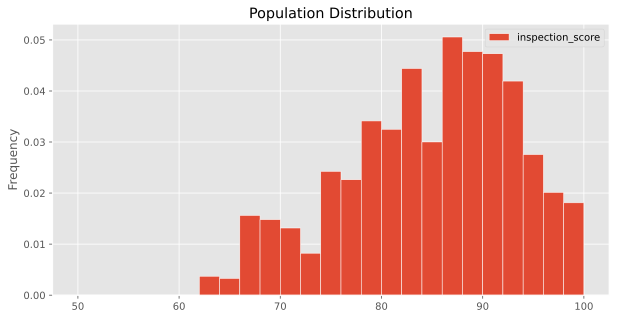

In [60]:
bakeries.plot(kind='hist', y='inspection_score', density=True, bins=score_bins, ec='w', figsize=(10, 5),
              title='Population Distribution');

For reference, the mean and standard deviation of the population distribution are calculated below.

In [63]:
bakeries.get('inspection_score').describe()

count    1216.00
mean       84.20
std         8.35
          ...   
50%        86.00
75%        90.00
max       100.00
Name: inspection_score, Length: 8, dtype: float64

In this case we happen to have the inspection scores for all members of the population, but in reality we won't. So let's instead consider a random **sample** of the population.

_Aside: Does the `.sample` method sample with or without replacement by default?_

In [65]:
np.random.seed(23) # Ignore this

sample_of_bakeries = bakeries.sample(200)
sample_of_bakeries

,business_name,inspection_date,inspection_score,risk_category,Neighborhoods,Zip Codes
33359,Universal Bakery Inc.,2019-01-28T00:00:00.000,83.0,Low Risk,2.0,28859.0
19980,Cherry Blossom Bakery 2,2016-06-28T00:00:00.000,90.0,Moderate Risk,NaN,NaN
29825,Waterfront Bakery,2018-06-07T00:00:00.000,94.0,Low Risk,32.0,308.0
...,...,...,...,...,...,...
4835,Marla Bakery,2018-09-10T00:00:00.000,91.0,High Risk,NaN,NaN
26932,PRINCESS BAKERY,2016-08-16T00:00:00.000,79.0,Low Risk,5.0,28861.0
34201,Castro Tarts Cafe and Bakery Inc.,2017-08-23T00:00:00.000,82.0,Low Risk,NaN,NaN


We can plot the sample distribution:

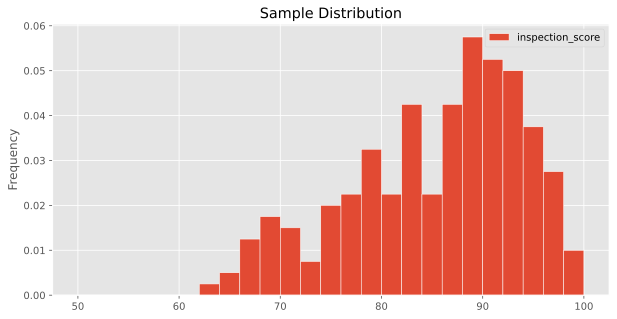

In [66]:
sample_of_bakeries.plot(kind='hist', y='inspection_score', density=True, bins=score_bins, ec='w', figsize=(10, 5),
                        title='Sample Distribution');

Note that since we took a large, random sample of the population, we expect that our sample looks similiar to the population and has a similar mean and SD.

In [68]:
sample_of_bakeries.get('inspection_score').describe()

count    200.00
mean      84.67
std        8.38
          ...  
50%       87.00
75%       91.25
max       98.00
Name: inspection_score, Length: 8, dtype: float64

Indeed, the sample mean is quite close to the population mean, and the sample standard deviation is quite close to the population standard deviation.

Let's suppose we want to estimate the population mean (that is, the mean inspection score of all bakeries in SF).

One estimate of the population mean is the mean of our sample.

In [69]:
sample_of_bakeries.get('inspection_score').mean()

84.665

However, our sample was random and could have been different, meaning our sample mean could also have been different.

**Question**: What's a reasonable range of possible values for the sample mean? **What is the distribution of the sample mean?**

### The Central Limit Theorem

> The Central Limit Theorem (CLT) says that the probability distribution of the **sum or mean** of a large random sample drawn with replacement will be roughly normal, regardless of the distribution of the population from which the sample is drawn.

In [70]:
show_clt_slides()

To see an empirical distribution of the sample mean, let's take a large number of samples directly from the population and compute the mean of each one.

Remember, in real life we wouldn't be able to do this, since we wouldn't have access to the population.

In [80]:
sample_means = np.array([])

for i in range(5000):
    sample_mean = bakeries.sample(200).get('inspection_score').mean()
    sample_means = np.append(sample_means, sample_mean)

In [72]:
sample_means

array([84.34, 85.02, 83.79, ..., 84.64, 84.49, 84.17])

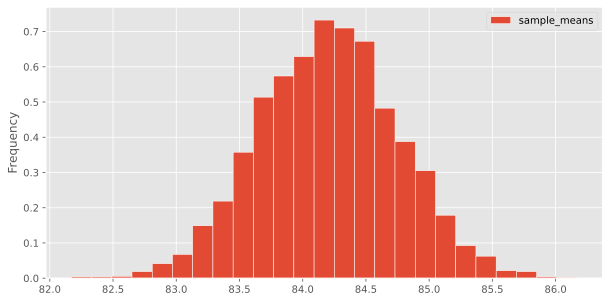

In [73]:
bpd.DataFrame().assign(sample_means=sample_means).plot(kind='hist', density=True, ec='w', bins=25, figsize=(10, 5));

Unsurprisingly, the distribution of the sample mean is bell-shaped. The CLT told us that!

The CLT also tells us that

$$\text{SD of Distribution of Possible Sample Means} = \frac{\text{Population SD}}{\sqrt{\text{sample size}}}$$



Let's try this out.

In [81]:
np.std(bakeries.get('inspection_score')) / np.sqrt(200)

0.5904894545352809

In [82]:
np.std(sample_means)

0.5391648661399869

Pretty close! Remember that `sample_means` is an array of simulated sample means; the more samples we simulate, the closer that `np.std(sample_means)` will get to the SD described by the CLT.

Note that in practice, we won't have the SD of the population, since we'll usually just have a single sample. In such cases, we can use the SD of the sample as an estimate of the SD of the population:

In [83]:
np.std(sample_of_bakeries.get('inspection_score')) / np.sqrt(200)

0.5909855116667413

Using the CLT, we have that the distribution of the sample mean:
- is roughly normal,
- is centered at the population mean (for which the sample mean is an estimate), and
- has a standard deviation of $\frac{\text{Population SD}}{\sqrt{\text{sample size}}}$ (which can be estimated using $\frac{\text{Sample SD}}{\sqrt{\text{sample size}}}$).

Using this information, we can build a confidence interval for where we think the population mean might be. A 95% confidence interval for the population mean is given by

$$
\left[
\text{sample mean} - 2\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}}, \
\text{sample mean} + 2\cdot \frac{\text{sample SD}}{\sqrt{\text{sample size}}}
\right]
$$

In [77]:
sample_mean = sample_of_bakeries.get('inspection_score').mean()
sample_std = np.std(sample_of_bakeries.get('inspection_score'))

In [79]:
lower = sample_mean - 2 * (sample_std/(200**0.5)) 
higher = sample_mean + 2 * (sample_std/(200**0.5))
[lower, higher]

[83.48302897666652, 85.8469710233335]

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

Using a single sample of 200 bakeries, how can we estimate the **median** inspection score of all bakeries in San Francisco with an inspection score? What technique should we use?

A. Standard hypothesis testing

B. Permutation testing  

C. Bootstrapping

D. The Central Limit Theorem

<details>
<summary>Click for the answer <b>after</b> you've entered your guess above. <b>Don't scroll any further.</b></summary>
    
Bootstrapping. The CLT only applies to sample means (and sums), not to any other statistics.

</details>

There is no CLT for sample medians, so instead we'll have to resort to bootstrapping to estimate the distribution of the sample median.

Recall, bootstrapping is the act of **sampling from the original sample, with replacement**. This is also called **resampling**.

In [84]:
# The median of our original sample – this is just one number
sample_of_bakeries.get('inspection_score').median()

87.0

In [85]:
# The median of a single bootstrap resample – this is just one number
sample_of_bakeries.get('inspection_score').sample(200, replace=True).median()

88.0

Let's resample repeatedly.

In [86]:
np.random.seed(23) # Ignore this

boot_medians = np.array([])

for i in range(5000):
    boot_medians = np.append(boot_medians, sample_of_bakeries.get('inspection_score').sample(200, replace=True).median())

In [87]:
boot_medians

array([87. , 85. , 86.5, ..., 87.5, 88. , 86. ])

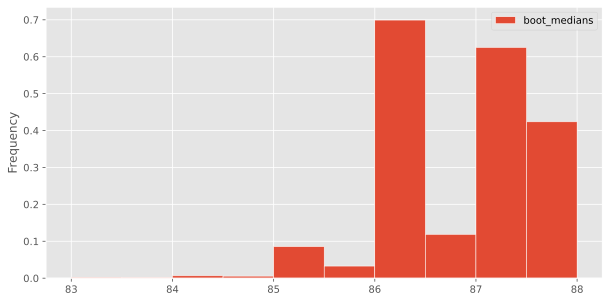

In [88]:
bpd.DataFrame().assign(boot_medians=boot_medians).plot(kind='hist', density=True, ec='w', bins=10, figsize=(10, 5));

Note that this distribution is not at all normal.

To compute a 95% confidence interval, we take the middle 95% of the bootstrapped medians.

In [90]:
left = np.percentile(boot_medians, 2.5)
right = np.percentile(boot_medians, 97.5)
[left, right]

[85.0, 88.0]

### Discussion Question

Which of the following interpretations of this confidence interval are valid?

1. 95% of SF bakeries have an inspection score between 85 and 88.  
2. 95% of the resamples have a median inspection score between 85 and 88.  
3. There is a 95% chance that our sample has a median inspection score between 85 and 88.  
4. There is a 95% chance that the median inspection score of all SF bakeries is between 85 and 88.  
5. If we had taken 100 samples from the same population, about 95 of these samples would have a median inspection score between 85 and 88.  
6.  If we had taken 100 samples from the same population, about 95 of the confidence intervals created would contain the median inspection score of all SF bakeries.  

<details>
<summary>Click for the answer <b>after</b> you've entered your guess above. <b>Don't scroll any further.</b></summary>
    
The correct answers are Option 2 and Option 6.

</details>

## Next time

### Next time

- One more review example.
- A high-level overview of the quarter.
- Some parting thoughts.